# Initial set up 
The whole script sets up the Cloudant database to include indexes, views, geohashes in the RF Checker database

import or install cloudant database library

In [1]:
import sys
# import Cloudant Library. Install if necessary
try:
    import cloudant
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install --pre cloudant 
    else:
        !pip install --user --pre cloudant
    import cloudant

# import geoHash Library. Install if necessary
try:
    import geohash2 as Geohash
except:
    if hasattr(sys, 'real_prefix'):
        #we are in a virtual env.
        !pip install geohash2
    else:
        !pip install --user geohash2
    import geohash2 as Geohash

Credentials for cloudant database on Bluemix

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
signal_db= 'rf-checker-geojson'
geohash_db="rf-geohash"
rf_credentials = {
    "cloudantNoSQLDB": [
        {
            "credentials": credentials_1,
            "syslog_drain_url": '/dev/null',
            "label": "cloudantNoSQLDB",
            "provider": 'IBM',
            "plan": "Lite",
            "name": "Cloudant NoSQL DB"
        }
    ]
}

# Define Indexes

Define the indexes that will be put into Cloudant

In [4]:
ddoc_geosignal='geosignal'
ddoc_geohash='geohash'

cloudant_indexes = [
    {
        'name': 'create a View for all geohashed records',
        'type': 'view',
        'database': signal_db,
        'ddoc': ddoc_geosignal,
        'indexName': 'geohashView',
        'javascript' : '\
function (doc) {\n\
  if (doc && doc.geohash){\n\
      emit(doc.geohash[0], null);\n\
      emit(doc.geohash[1], null);\n\
      emit(doc.geohash[2], null);\n\
      emit(doc.geohash[3], null);\n\
  }\n\
}\
        ',
    },
    {
        'name': 'Create a view to find all GeoJson records without a geohash',
        'type': 'view',
        'database': signal_db,
        'ddoc': ddoc_geosignal,
        'indexName': 'noGeohashView',
        'javascript' : '\
function (doc) {\n\
  if (doc.geometry && !doc.geohash)\n\
    emit(doc._id, null);\n\
}\
        ',
    },
    {
        'name': 'create -85 dbm index - strong signal',
        'type': 'geo',
        'database': signal_db,
        'ddoc': ddoc_geosignal,
        'indexName': 'towerIndex',
        'javascript' : '\
function (doc) {\n\
  if (doc.geometry && doc.geometry.coordinates && doc.id == "tower") {\n\
    st_index(doc.geometry);\n\
  }\n\
}\
        ',
    },
    {
        'name': 'create car index',
        'type': 'geo',
        'database': signal_db,
        'ddoc': ddoc_geosignal,
        'indexName': 'caridx',
        'javascript' : '\
function (doc) {\n\
    if (doc && doc.id === "signal-strength"){\n\
      if (doc.properties && doc.properties.gpsSpeed > 2.0 && \n\
          doc.geometry.coordinates && doc.geometry.coordinates.length > 0) \n\
        st_index(doc.geometry);\n\
    }\n\
}\
        ',
    },
    { 
        'name': 'create standard geo index',
        'type': 'geo',
        'database': geohash_db,
        'ddoc': ddoc_geosignal,
        'indexName' : 'geoidx',
        'javascript' : '\
function(doc) { \n\
    if (doc.geometry && doc.geometry.coordinates && doc.geometry.coordinates.length > 0) { \n\
        st_index(doc.geometry);\n\
    } \n\
} \
        ',
    },
    {
        'name': 'create walking index',
        'type': 'geo',
        'database': signal_db,
        'ddoc': ddoc_geosignal,
        'indexName': 'walkidx',
        'javascript' : '\
function (doc) {\n\
    if (doc && doc.id === "signal-strength"){\n\
      if (doc.properties && doc.properties.gpsSpeed <= 2.0 && \n\
          doc.geometry.coordinates && doc.geometry.coordinates.length > 0) \n\
        st_index(doc.geometry);\n\
    }\n\
}\
        ',
    },
    {
        'name': 'create a standard index',
        'type': 'search',
        'database': signal_db,
        'ddoc': ddoc_geosignal,
        'indexName': 'geohashIndex',
        'javascript' : '\
function (doc) {\n\
  if (doc.geohash) {\n\
    index(doc.geohash[0], doc);\n\
    index(doc.geohash[1], doc);\n\
    index(doc.geohash[2], doc);\n\
    index(doc.geohash[3], doc);\n\
  }\n\
}\
        ',
    },
    {
        'name': 'create a standard index',
        'type': 'search',
        'database': signal_db,
        'ddoc': ddoc_geosignal,
        'indexName': 'ididx',
        'javascript' : '\
function (doc) {\n\
  index("id", doc.id);\n\
}\
        ',
    },
    {
        'name': 'create a standard index',
        'type': 'query index',
        'database': geohash_db,
        'ddoc': ddoc_geohash,
        'indexName': 'geohash-index',
        'query type' : 'json',
        'fields': [
            'id', 
            'properties.signalStrengthMean'
        ]
    } 
]

Create (or recreates) the indexes into cloudant. WARNING! *All* indexes in the 'geosignal' design document are deleted

In [5]:
# design doc used to store all indexes and views

def deleteAllIndexes(db):
    # Delete all the indexes and design documents
    ddocs = [ddoc_geosignal, ddoc_geohash]
    for ddoc_name in ddocs:
        ddoc = db.get_design_document('_design/' + ddoc_name)
        for i in ddoc.list_indexes():
            ddoc.delete_index(i)
        for i in ddoc.list_views():
            ddoc.delete_view(i)
        #ddoc.save()
   ## what about cloudant queryIndexes

#indexes contains only indexes for the specifc Design Document
def addIndexesToDesignDocument(db, ddocName, indexes):
    # add search indexes
    idx = [i for i in indexes if i['type'] in ['search', 'geo',' view'] ]
    if len(idx) > 0:
        ddoc = db.get_design_document('_design/' + ddocName)
        for query in [i for i in indexes if i['type'] == 'search']:
            ddoc.add_search_index(query['indexName'], query['javascript']) 
    
        # add views
        for query in [i for i in indexes if i['type'] == 'view']:
            ddoc.add_view(query['indexName'], query['javascript']) 
    
        # set up the geospatial index
        queries = [ i for i in indexes if i['type'] == 'geo']
        if len(queries) > 0:
            ddoc['st_indexes'] = { i['indexName']: { 'index' : i['javascript']} for i in queries }
        # forces the remote DB to be updated
        ddoc.save()
    
    # Create the queryIndex
    for query in [i for i in indexes if i['type'] == 'query index']:
        db.create_query_index(
            index_name=query['indexName'],
            index_type=query['query type'],
            fields=query['fields']
        )

def addAllIndexesTo(db, dbName):
    designDocs = [ddoc_geosignal, ddoc_geohash] 
    for ddoc_name in designDocs:
        indexes = [i for i in cloudant_indexes if i['database'] == dbName and i['ddoc'] == ddoc_name]
        addIndexesToDesignDocument(db,ddoc_name,indexes)

Recreates the indexes in the database

In [7]:
with cloudant.cloudant_bluemix(rf_credentials,'Cloudant NoSQL DB') as client:
    dbs = [geohash_db, signal_db]
    
    # delete all the indexes
    for dbName in dbs:
        db = client[dbName]
        deleteAllIndexes(db)
    
    # create all the indexes in the databases
    for dbName in dbs:
        db = client[dbName]
        addAllIndexesTo(db,dbName)

Add the three main Verizon towers around the signals data.
I got the following map image from [http://www.cellreception.com](http://www.cellreception.com/towers/towers.php?filter_verizon=1&city=denver&state_abr=co)
I can not honestly say if this is accurate but the 3 central cell towers shown are added to the signals DB
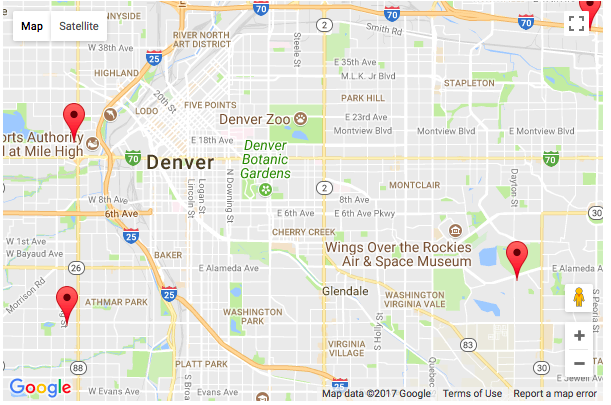

In [8]:
import geojson

towerPoints = [
    geojson.Point((-105.0298461, 39.6959729), properties={
        'address': '3201 W Arizona, Denver, CO'
    }),
    geojson.Point((-104.8754721, 39.7083522), properties={
        'address': '9770 E Alameda Ave., Denver, CO'
    }),
    geojson.Point((-105.026617, 39.742919), properties={
        'address': '2505 West 16th Ave., Denver, CO'
    })
]

# Stores the Verizon Towers
with cloudant.cloudant_bluemix(rf_credentials,'Cloudant NoSQL DB') as client:
    db = client[signal_db]
    towers = []
    for towerPoint in towerPoints:
        feature = geojson.Feature(geometry=towerPoint, properties=towerPoint['properties'])
        feature['id'] = 'tower'
        towers.append(feature)    
    db.bulk_docs(towers)

# Add Geohash

Add the geohash for each GeoJson document in the database. This will allow us to group signal stengths together into a group.
We will add several geohashes that will eventually be indexed/or added to views.
The precision of each geohash is approximate depending on the digits of precision.

| Length | Cell width | Cell height |
|--------|------------|-------------|
|1       | ≤ 5,000km  | 5,000km     |
|2 	     | ≤ 1,250km  | 625km       |
|3 	     | ≤ 156km    | 156km       |
|4 	     | ≤ 39.1km   | 19.5km      |
|5 	     | ≤ 4.89km   | 4.89km      |
|6 	     | ≤ 1.22km   | 0.61km      |
|7 	     | ≤ 153m 	  | 153m        |
|8 	     | ≤ 38.2m 	  | 19.1m       |
|9 	     | ≤ 4.77m 	  | 4.77m       | 
|10 	 | ≤ 1.19m 	  | 0.596m      |
|11 	 | ≤ 149mm 	  | 149mm       |
|12 	 |≤ 37.2mm 	  | 18.6mm      |

The information was gleamed from an article by [Stefan Kruger](https://medium.com/@xpqz/geohashing-for-fun-and-profit-in-cloudant-989420fe1e73) and from a [StackExchange posting](https://gis.stackexchange.com/questions/115280/what-is-the-precision-of-a-geohash)

[geohash documentaion](https://pypi.python.org/pypi/Geohash/) for Python 3 uses the [geocash2 package on Github](https://github.com/dbarthe/geohash/)

Here are all the [geohash packages](https://pypi.python.org/pypi?%3Aaction=search&term=geohash&submit=search) you can use in Python

Set up some useful convenience functions

In [11]:
from cloudant import cloudant_bluemix

# remove the annoying 'doc' tag from the rows
def removeDocTag(queryResult):
    if len(queryResult['rows']) > 0 and 'doc' in queryResult['rows'][0]:
        queryResult['rows'] = [item['doc'] for item in queryResult['rows']]
    return queryResult

# Retrieves docuents based on an index and a query
def getViewDocs(db, index):
    limit = 200
    queryResult = db.get_view_result(ddoc_geosignal, index, include_docs=True, limit=limit, raw_result=True)
    return removeDocTag(queryResult)

# adds a geohash element to each document if one is NOT present
def addGeohash(doc):
    if 'geohash' in doc:
        pass
    else:
        lat = doc['geometry']['coordinates'][1]
        long = doc['geometry']['coordinates'][0]
        doc['geohash'] = [
            Geohash.encode(lat, long, precision=7),
            Geohash.encode(lat, long, precision=8),
            Geohash.encode(lat, long, precision=9),
            Geohash.encode(lat, long, precision=10)
        ]

Only updates GeoJson documents that have **not** got a geohash item

In [12]:
numRows = 0
with cloudant_bluemix(rf_credentials,'Cloudant NoSQL DB') as client:
    db = client[signal_db]
    index = 'noGeohashView'
    while True:
        queryResult = getViewDocs(db, index)
        if queryResult['total_rows'] == 0:
            break
        for doc in queryResult['rows']:
            numRows = numRows + 1
            addGeohash(doc)
        # update all documents
        db.bulk_docs(queryResult['rows'])
        # The free version of cloudant limits the number of call/sec to 5
        if (numRows + 1) % 5 == 0:
            time.sleep(0.5)
numRows

4353

Store the new Geohash data into DashDB (DB2 Warehouse on the Cloud)

In [ ]:
# The code was removed by Watson Studio for sharing.

In [ ]:
# The code was removed by Watson Studio for sharing.

In [ ]:
numRows = 0

def storeInDashDB(doc):
    
    
    
with cloudant_bluemix(rf_credentials,'Cloudant NoSQL DB') as client:
    db = client[signal_db]
    index = 'geohashView'
    while True:
        queryResult = getViewDocs(db, index)
        if queryResult['total_rows'] == 0:
            break
        for doc in queryResult['rows']:
            numRows = numRows + 1
            #write these into DashDB
            storeInDashDB(doc)
        
        # The free version of cloudant limits the number of call/sec to 5
        if (numRows + 1) % 5 == 0:
            time.sleep(0.5)
numRows